In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect,func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/_c/6ryw2m_11jnf16xxb6k7rbj59hv3vh/T/ipykernel_18173/4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#Finding columns and datatype
from sqlalchemy import inspect,func
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
# Earliest Date # session.query(Measurement.date).order_by(Measurement.date).first()
# Find the most recent date in the data set (latest).
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
Result_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
str_date = list(np.ravel(Result_date))[0]
latest_date = dt.datetime.strptime(str_date,"%Y-%m-%d")
last_twelve_months = latest_date-dt.timedelta(days=366)

# # Perform a query to retrieve the data and precipitation scores
yearprecipt=session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.asc()).\
filter(Measurement.date>=last_twelve_months).all()

# # Save the query results as a Pandas DataFrame and set the index to the date column
df_yearprecipt=pd.DataFrame(yearprecipt)
df_yearprecipt.head()
df_yearprecipt=df_yearprecipt.rename(columns={"prcp":"precipitation"})
df_yearprecipt.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [18]:
# Sort the dataframe by date
df_yearprecipt.sort_values(by=['date'],ascending = True)
df_yearprecipt = df_yearprecipt.dropna()
df_yearprecipt=df_yearprecipt.reset_index(drop=True)
df_yearprecipt.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,0.02
4,2016-08-23,1.79


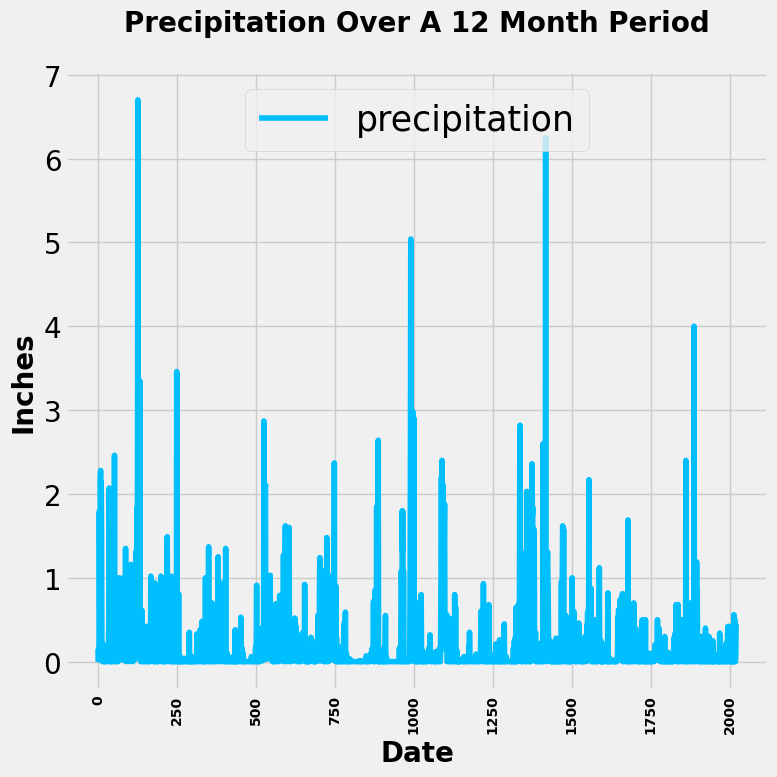

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
plotprcp_12 = df_yearprecipt.plot(figsize = (8, 8), color = 'deepskyblue', alpha = 1.0);
plotprcp_12.set_xlabel("Date",weight = "bold",size=20);
plotprcp_12.set_ylabel("Inches", weight="bold", size=20);
plotprcp_12.set_title("Precipitation Over A 12 Month Period\n", weight="bold", size=20);

# # Added after plot.legend()
plt.xticks(rotation=90, fontsize=10, weight="bold")
plt.yticks(fontsize=20)

# # size doesn't work for .legend() change to fontsize
plt.legend(loc="upper center", fontsize=25)

# # plot.grid()
plt.tight_layout()

plt.savefig("Precipitation12months.png")

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_yearprecipt.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number of stations in the dataset
station_count=session.query(func.count(Station.id)).all()
station_count

[(9,)]

In [22]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_Measurment_join=session.query(Measurement.station,func.count(Measurement.station)).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).all()
station_Measurment_join

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_temp_station=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station==station_Measurment_join[0][0]).all()
most_temp_station


[(54.0, 85.0, 71.66378066378067)]

In [24]:
# identify the most station
station_Measurment_join[0][0]

'USC00519281'

In [25]:
tobs_overayear = session.query(Measurement.station, Station.name, Measurement.date, Measurement.tobs).\
filter(Measurement.station == Station.station).\
filter(Measurement.station == "USC00519281").\
filter(Measurement.date >= "2016-08-23").\
filter(Measurement.date <= "2017-08-23").\
order_by(Measurement.date).all()

In [26]:
tobs_overayear_df = pd.DataFrame(tobs_overayear)
tobs_overayear_df = tobs_overayear_df.rename(columns={"station" : "station", "name" : "Name", "date" : "Date", "tobs" : "tobs"})
tobs_overayear_df.head()


,station,Name,Date,tobs
0,USC00519281,"WAIHEE 837.5, HI US",2016-08-23,77.0
1,USC00519281,"WAIHEE 837.5, HI US",2016-08-24,77.0
2,USC00519281,"WAIHEE 837.5, HI US",2016-08-25,80.0
3,USC00519281,"WAIHEE 837.5, HI US",2016-08-26,80.0
4,USC00519281,"WAIHEE 837.5, HI US",2016-08-27,75.0


<function matplotlib.pyplot.show(close=None, block=None)>

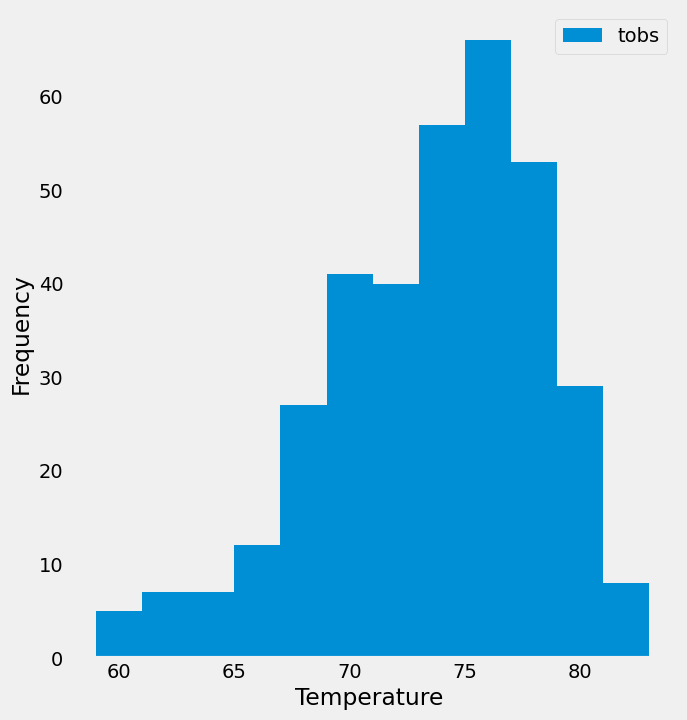

In [27]:
# hist = df_results['tobs'].hist(bins=12,figsize=(8,5), color='b', zorder=2)
tobs_overayear_df.plot.hist(bins=12, figsize=(7,8))
plt.grid()
plt.xlabel("Temperature ")
plt.savefig("StationTemps.png")
plt.show

# Close Session

In [28]:
# Close Session
session.close()